In [4]:
import sys
import os

# project_path = '/workspace/apolune'
project_path = '/Users/hofmannc/git/apolune'
sys.path.append(project_path)

import numpy as np
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve, approx_fprime
import matplotlib.pyplot as plt
import glob

from guess_generation.API import api_get

import spiceypy as spice
import init.load_kernels as krn

import propagation.propagator as propagation
import dynamics.crtbp_dynamics as crtbp
import dynamics.rnbp_rpf_utils as utils
import dynamics_coeff.rnbp_rpf_utils as rnbp_utils
from dynamics_coeff.rnbp_rpf_dynamics_nonuniform_jit import get_body_states, compute_epoch_time

import frames.crtbp_transformations as crtbp_frame
import utils.utils as utils

In [23]:
krn.load_kernels()

# (index, spice_id) pairs
id_mer = [0, 1]
id_ven = [1, 2]
id_ear = [2, 399]
id_mar = [3, 4]
id_jup = [4, 5]
id_sat = [5, 6]
id_ura = [6, 7]
id_nep = [7, 8]
id_plu = [8, 9]
id_moo = [9, 301]
id_sun = [10, 10]

# Standard gravitational parameter ( μ [km^3 s−2] )
GM_sun = spice.bodvrd(str(id_sun[1]), "GM", 1)[1][0] 
GM_mer = spice.bodvrd(str(id_mer[1]), "GM", 1)[1][0] 
GM_ven = spice.bodvrd(str(id_ven[1]), "GM", 1)[1][0] 
GM_ear = spice.bodvrd(str(id_ear[1]), "GM", 1)[1][0] 
GM_moo = spice.bodvrd(str(id_moo[1]), "GM", 1)[1][0] 
GM_mar = spice.bodvrd(str(id_mar[1]), "GM", 1)[1][0] 
GM_jup = spice.bodvrd(str(id_jup[1]), "GM", 1)[1][0] 
GM_sat = spice.bodvrd(str(id_sat[1]), "GM", 1)[1][0] 
GM_ura = spice.bodvrd(str(id_ura[1]), "GM", 1)[1][0] 
GM_nep = spice.bodvrd(str(id_nep[1]), "GM", 1)[1][0] 
GM_plu = spice.bodvrd(str(id_plu[1]), "GM", 1)[1][0] 

id_bodies = np.array([id_mer[0], id_ven[0], id_ear[0], id_mar[0], id_jup[0], id_sat[0], id_ura[0], id_nep[0], id_plu[0], id_moo[0], id_sun[0]])
naif_id_bodies = np.array([id_mer[1], id_ven[1], id_ear[1], id_mar[1], id_jup[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1], id_moo[1], id_sun[1]])
mu_bodies = np.array([GM_mer, GM_ven, GM_ear, GM_mar, GM_jup, GM_sat, GM_ura, GM_nep, GM_plu, GM_moo, GM_sun])

id_primary = id_sun[0]
id_secondary = id_ear[0]


In [168]:
G = 6.67408e-20  # [km^3 kg^−1 s^−2]
AU = 1.495978706136889e+08 # [km] from SPICE
g0_dim = 9.80665e-3 # [km s^-2]

M_earth = GM_ear / G
M_moon = GM_moo / G
M_sun = GM_sun / G

# earth-moon system
# M_em = M_earth + M_moon # m_earth + m_moon [kg]
# mu = 1.21506683e-2 # m_moon / (m_earth + m_moon)
# LU = 3.84405000e5 # km
# TU = 375197.5822850085 # seconds
# VU = LU / TU # km/s
# ACU = VU / TU # Acceleration unit [km/s^2]

# sun-earth system
M_sun_earth = M_sun + M_earth # m_sun + m_earth + m_moon [kg]
mu = M_earth / M_sun_earth # m_earth / (m_earth + m_sun)
LU = AU # km
TU = np.sqrt(LU**3 / (G * M_sun_earth)) # seconds
VU = LU / TU # km/s
ACU = VU / TU # Acceleration unit [km/s^2]

ode_rtol = 1e-12
ode_atol = 1e-12

pos_p = np.array([-mu, 0.0, 0.0])
pos_s = np.array([1-mu, 0.0, 0.0])

om0 = 1 / TU
# epoch_t0_string = "20 March 2024 09:39:03 TDB"
# epoch_t0_string = "9 March 2024 09:39:03 TDB"
epoch_t0_string = "8 March 2024 12:10:00 TDB"
epoch_t0 = spice.str2et(epoch_t0_string)
abcorr_flag = "None"
observer_id = 0
# observer_id = id_ear[1]
reference_frame = "J2000"

param_dict = {'mu': mu, 'ode_atol': ode_atol, 'ode_rtol': ode_rtol, \
              'mu_bodies': mu_bodies, 'id_primary': id_primary, 'id_secondary': id_secondary, 'naif_id_bodies': naif_id_bodies, \
                'om0': om0, 'epoch_t0': epoch_t0, 'abcorr_flag': abcorr_flag, 'observer_id': observer_id, 'reference_frame': reference_frame}

auxdata = {'param': param_dict}


In [169]:
guess_folder = "/Users/hofmannc/git/apolune/guess_generation/saved_guess_trajectories/"
guess_names = "threebody_guesses*.npy"
tf_list = []

for path_to_file in glob.glob(os.path.join(guess_folder, guess_names)):
    crtbp_guess = np.load(path_to_file, allow_pickle=True)
    data = crtbp_guess[0]
    tf = data["tf"]
    tf_list.append(tf)

tf_list_days = np.array(tf_list) * TU / 86400

In [170]:

guess_folder = "/Users/hofmannc/git/apolune/guess_generation/saved_guess_trajectories/"
# guess_folder = "/Users/hofmannc/git/apolune/guess_generation/"
guess_filename = "threebody_guesses_3.000645.npy"
# guess_filename = "threebody_guesses_3.0008038693467336.npy"
# guess_filename = "threebody_guesses_3.0008008040201006.npy"
# guess_filename = "threebody_guesses_3.0007381818181815.npy"
crtbp_guess = np.load(guess_folder + guess_filename, allow_pickle=True) 

N = 100
data = crtbp_guess[0]
state0 = np.array(data["x0"])
tf = data["tf"]
t0 = 0.0
time = np.linspace(t0, tf, N)

# epoch_start = data["start_epoch"]
# epoch_end = data["end_epoch"]
# delta_epoch = epoch_end - epoch_start
# delta_epoch_days = delta_epoch / 86400

state_prop = propagation.propagate_odeint(crtbp.dynamics, state0, np.empty(0), np.empty(0), time, auxdata)
# result = propagation.propagate_ivp(crtbp.dynamics, state0, np.empty(0), np.empty(0), time, auxdata)

# state_prop = result.y.T


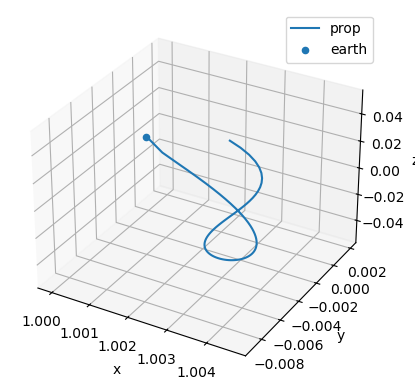

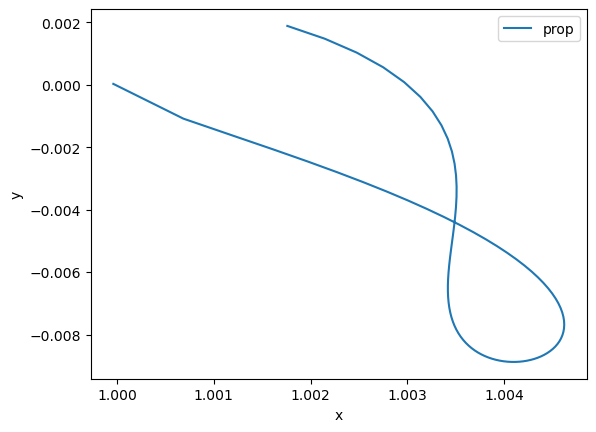

In [171]:
plt.figure(1)
ax = plt.axes(projection ='3d')
ax.plot(state_prop[:,0], state_prop[:,1], state_prop[:,2], label='prop')
ax.scatter(state_prop[0,0], state_prop[0,1], state_prop[0,2], label='earth')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()

fig, ax = plt.subplots()
ax.plot(state_prop[:,0], state_prop[:,1], label='prop')
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.legend()
plt.show()

In [172]:
state_prop_in = crtbp_frame.synodicToInertialEphemeris(time, state_prop, auxdata['param'])

num_bodies = len(mu_bodies)
time_in_epoch = time * TU + epoch_t0
# time_in_epoch = np.linspace(epoch_start, epoch_end, N)

ref_body_naif_id = id_ear[1]
# ref_body_naif_id = id_moo[1]
observer_id = 0
state_prop_in_from_ref = np.zeros((N,3))
for i in range(N):
    pos_body, _ = spice.spkgps(ref_body_naif_id, time_in_epoch[i], reference_frame, observer_id)
    state_prop_in_from_ref[i] = state_prop_in[i,:3] - pos_body

moon_pos_from_ref = np.zeros((N,3))
for i in range(N):
    pos_body, _ = spice.spkgps(id_moo[1], time_in_epoch[i], reference_frame, ref_body_naif_id)
    moon_pos_from_ref[i] = pos_body

acc_mag = np.zeros((N, num_bodies))
# observer_id = 0
observer_id = 399
# observer_id = id_moo[1]
# observer_id = naif_id_bodies[id_primary]
# observer_id = naif_id_bodies[id_secondary]
for i in range(N):
    # acc_mag_tmp, _ = utils.compute_perturbing_accelerations(time_in_epoch[i], state_prop_in[i,:3], mu_bodies, naif_id_bodies, id_primary, reference_frame, observer_id)
    # acc_mag_tmp, _ = utils.compute_perturbing_accelerations(time_in_epoch[i], state_prop_in[i,:3], mu_bodies, naif_id_bodies, id_secondary, reference_frame, observer_id)
    acc_mag_tmp, _ = utils.compute_perturbing_accelerations(time_in_epoch[i], state_prop_in_from_ref[i,:3], mu_bodies, naif_id_bodies, id_ear[0], reference_frame, observer_id)
    # acc_mag_tmp, _ = utils.compute_perturbing_accelerations(time_in_epoch[i], state_prop_in_from_ref[i,:3], mu_bodies, naif_id_bodies, id_moo[0], reference_frame, observer_id)
    acc_mag[i] = acc_mag_tmp


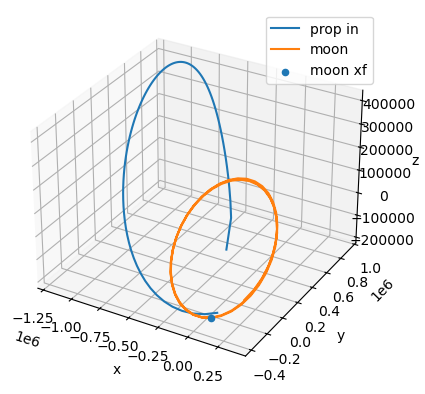

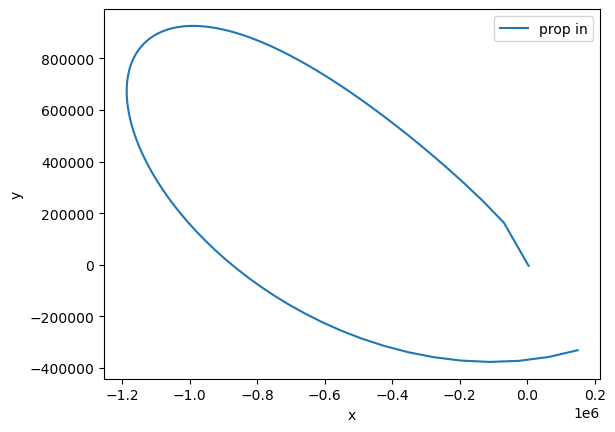

In [173]:
plt.figure()
ax = plt.axes(projection ='3d')
# ax.plot(state_prop_in[:,0], state_prop_in[:,1], state_prop_in[:,2], label='prop in')
ax.plot(state_prop_in_from_ref[:,0], state_prop_in_from_ref[:,1], state_prop_in_from_ref[:,2], label='prop in')
ax.plot(moon_pos_from_ref[:,0], moon_pos_from_ref[:,1], moon_pos_from_ref[:,2], label='moon')
ax.scatter(moon_pos_from_ref[-1,0], moon_pos_from_ref[-1,1], moon_pos_from_ref[-1,2], label='moon xf')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()

fig, ax = plt.subplots()
# ax.plot(state_prop_in[:,0], state_prop_in[:,1], label='prop in')
ax.plot(state_prop_in_from_ref[:,0], state_prop_in_from_ref[:,1], label='prop in')
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.legend()
plt.show()

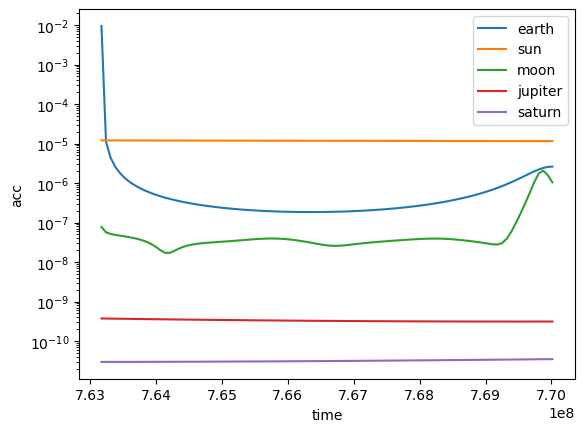

In [ ]:
id_earth_list = id_ear[0]
id_sun_list = id_sun[0]
id_moon_list = id_moo[0]
id_jupiter_list = id_jup[0]
id_saturn_list = id_sat[0]
id_ven_list = id_ven[0]
id_mar_list = id_mar[0]

plt.figure(1)
ax1 = plt.axes()
ax1.plot(time_in_epoch, acc_mag[:,id_earth_list], label='earth')
ax1.plot(time_in_epoch, acc_mag[:,id_sun_list], label='sun')
ax1.plot(time_in_epoch, acc_mag[:,id_moon_list], label='moon')
# ax1.plot(time_in_epoch, acc_mag[:,id_jupiter_list], label='jupiter')
# ax1.plot(time_in_epoch, acc_mag[:,id_saturn_list], label='saturn')
ax1.set_xlabel("time")
ax1.set_ylabel("acc")
ax1.set_yscale('log')
plt.legend()
plt.show()